<a href="https://colab.research.google.com/github/jysuhr/CRC_Simulation/blob/simulation/CRC_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# 예시로 'california_housing_train.csv' 파일을 사용합니다. 다른 CSV 파일을 로드하려면 경로를 변경하세요.
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/CRC_Analytics/Summary_Report_Statistics.csv'

try:
    df = pd.read_csv(csv_file_path)
    print(f"'{csv_file_path}' 파일이 성공적으로 로드되었습니다.")
    display(df.head())
except FileNotFoundError:
    print(f"오류: '{csv_file_path}' 파일을 찾을 수 없습니다. 올바른 경로인지 확인하세요.")
except Exception as e:
    print(f"파일을 로드하는 중 오류가 발생했습니다: {e}")

'/content/drive/MyDrive/Colab Notebooks/CRC_Analytics/Summary_Report_Statistics.csv' 파일이 성공적으로 로드되었습니다.


,CRC,DataLength,ErrorPercent,ErrorDetectionRate_%,AverageDelay_ms
0,CRC8,16,0,0.0000,0.002733
1,CRC8,16,1,100.0000,0.003725
2,CRC8,16,10,100.0000,0.004506
3,CRC8,16,20,99.9756,0.005102
4,CRC8,16,50,99.2432,0.006274


## 📊 데이터 요약 테이블

In [5]:
print('데이터프레임의 기술 통계량:')
display(df.describe())

데이터프레임의 기술 통계량:


,DataLength,ErrorPercent,ErrorDetectionRate_%,AverageDelay_ms
count,80.000000,80.0000,80.000000,80.000000
mean,135.000000,16.2000,79.911195,0.030521
std,126.390995,18.4942,40.208201,0.030215
min,16.000000,0.0000,0.000000,0.002733
25%,56.000000,1.0000,99.310300,0.010468
50%,96.000000,10.0000,100.000000,0.021310
75%,160.000000,20.0000,100.000000,0.040766
max,512.000000,50.0000,100.000000,0.164733


---

## 📈 CRC 유형별 평균 Error Detection Rate 바 플롯

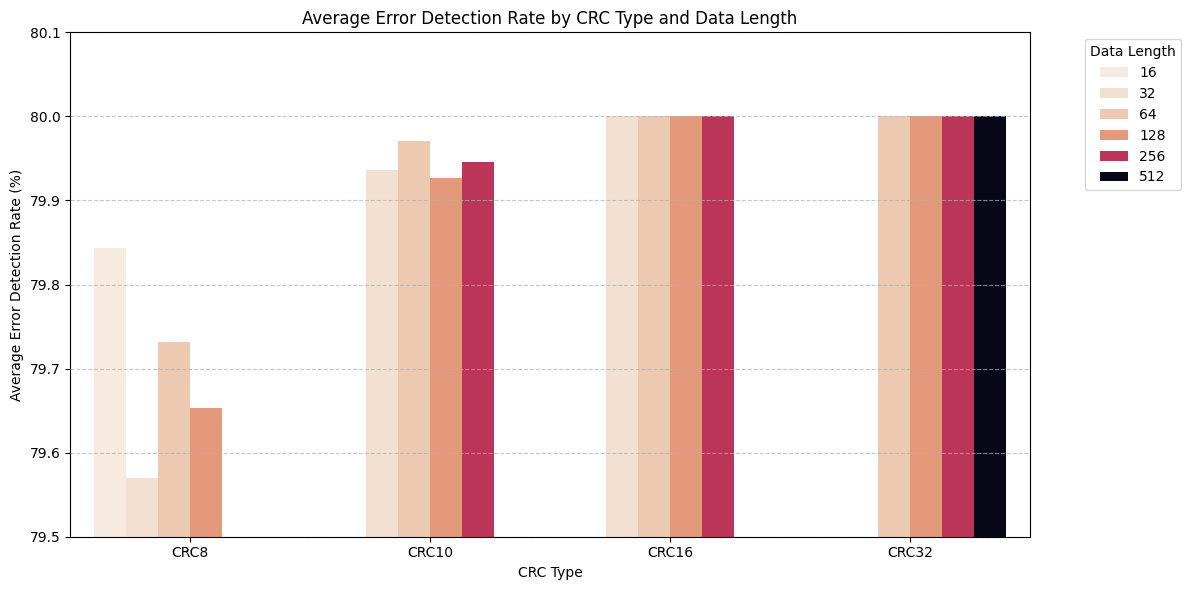

In [46]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='CRC', y='ErrorDetectionRate_%', estimator=lambda x: x.mean(), errorbar=None, palette='rocket_r', hue='DataLength')
plt.title('Average Error Detection Rate by CRC Type and Data Length')
plt.xlabel('CRC Type')
plt.ylabel('Average Error Detection Rate (%)')
plt.ylim(79.5, 80.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

## 🔥 CRC 유형 및 Data Length별 평균 Error Detection Rate 히트맵

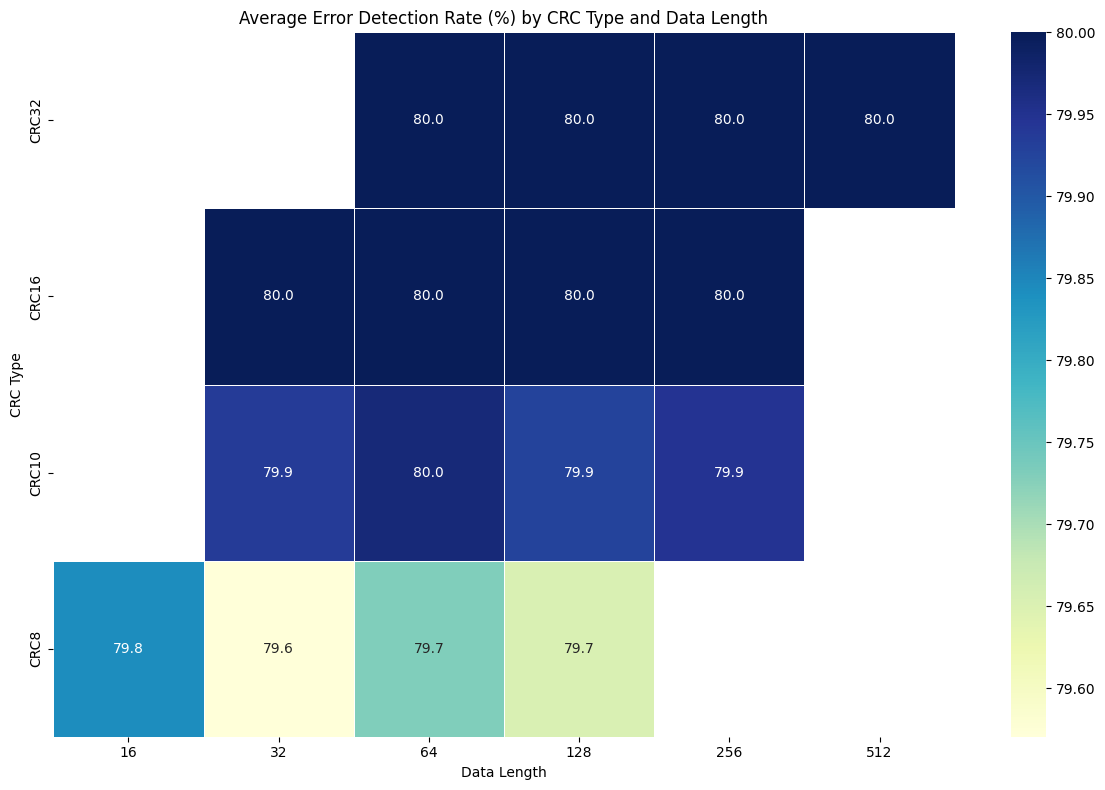

In [50]:
pivot_table = df.pivot_table(index='CRC', columns='DataLength', values='ErrorDetectionRate_%', aggfunc='mean')
custom_crc_order = ['CRC32', 'CRC16', 'CRC10', 'CRC8']
pivot_table = pivot_table.reindex(custom_crc_order)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Average Error Detection Rate (%) by CRC Type and Data Length')
plt.xlabel('Data Length')
plt.ylabel('CRC Type')
plt.tight_layout()
plt.show()

---

## 🎻 Data Length별 Average Delay Violin Plot

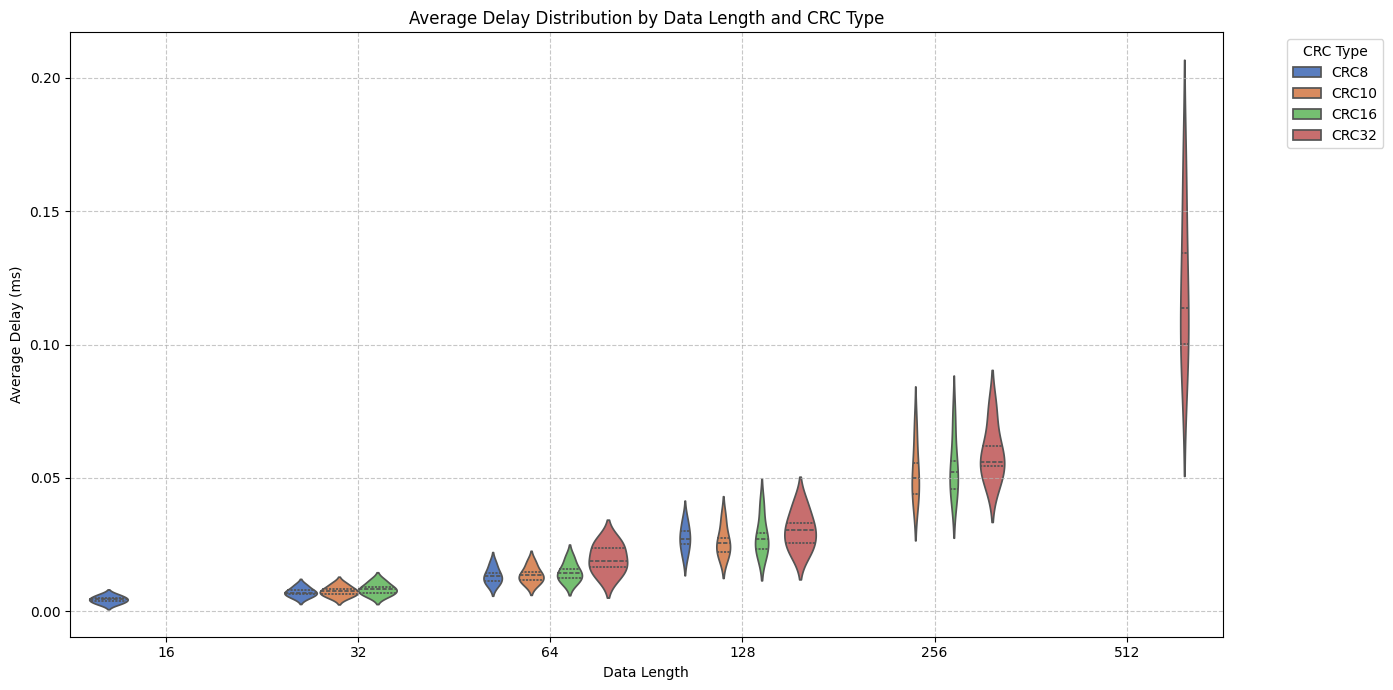

In [8]:
plt.figure(figsize=(14, 7))
sns.violinplot(data=df, x='DataLength', y='AverageDelay_ms', hue='CRC', palette='muted', inner='quartile')
plt.title('Average Delay Distribution by Data Length and CRC Type')
plt.xlabel('Data Length')
plt.ylabel('Average Delay (ms)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='CRC Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 📊 CRC8: Error Percentage별 Error Detection Rate

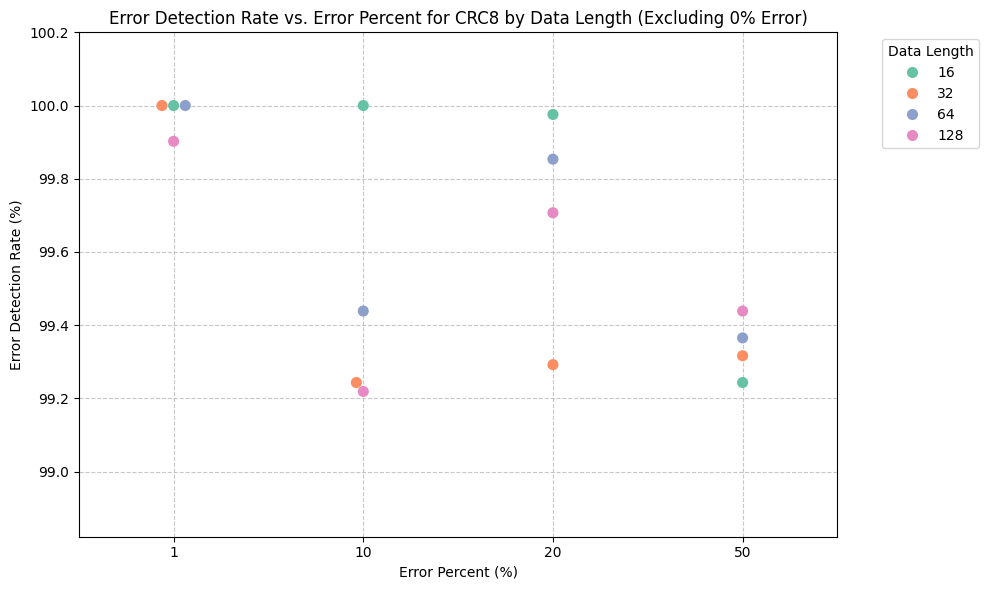

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# CRC8 데이터만 필터링하고 ErrorPercent가 0인 값 제외
df_crc8 = df[(df['CRC'] == 'CRC8') & (df['ErrorPercent'] != 0)]

plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_crc8, x='ErrorPercent', y='ErrorDetectionRate_%', hue='DataLength', palette='Set2', s=8)
plt.title('Error Detection Rate vs. Error Percent for CRC8 by Data Length (Excluding 0% Error)')
plt.xlabel('Error Percent (%)')
plt.ylabel('Error Detection Rate (%)')
plt.ylim(min(df_crc8['ErrorDetectionRate_%']) * 0.996, max(df_crc8['ErrorDetectionRate_%']) * 1.002)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 📊 CRC10: Error Percentage별 Error Detection Rate

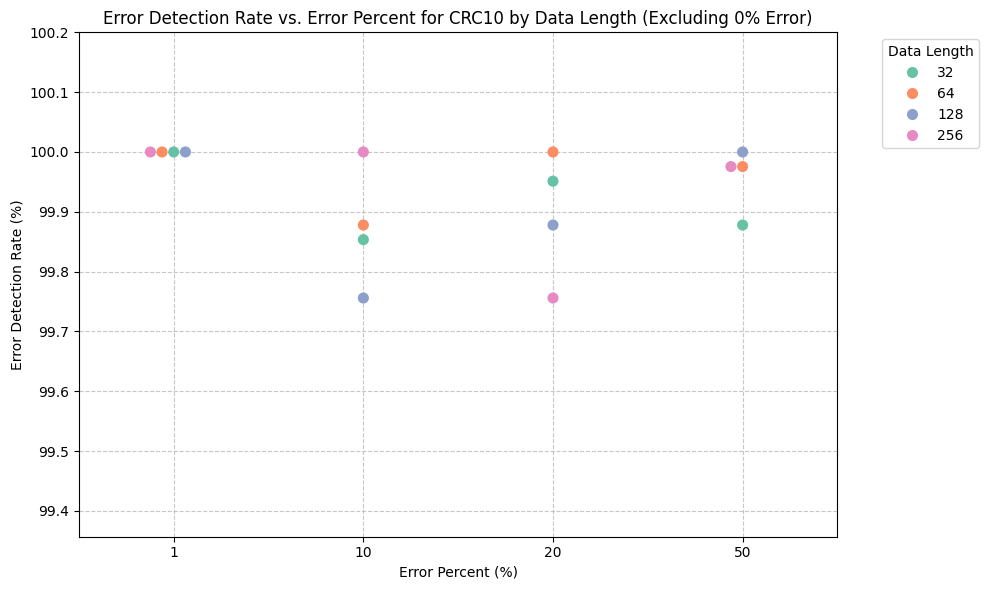

In [79]:
# CRC10 데이터만 필터링하고 ErrorPercent가 0인 값 제외
df_crc10 = df[(df['CRC'] == 'CRC10') & (df['ErrorPercent'] != 0)]

plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_crc10, x='ErrorPercent', y='ErrorDetectionRate_%', hue='DataLength', palette='Set2', s=8)
plt.title('Error Detection Rate vs. Error Percent for CRC10 by Data Length (Excluding 0% Error)')
plt.xlabel('Error Percent (%)')
plt.ylabel('Error Detection Rate (%)')
plt.ylim(min(df_crc10['ErrorDetectionRate_%']) * 0.996, max(df_crc10['ErrorDetectionRate_%']) * 1.002)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

## 📊 CRC16: Error Percentage별 Error Detection Rate

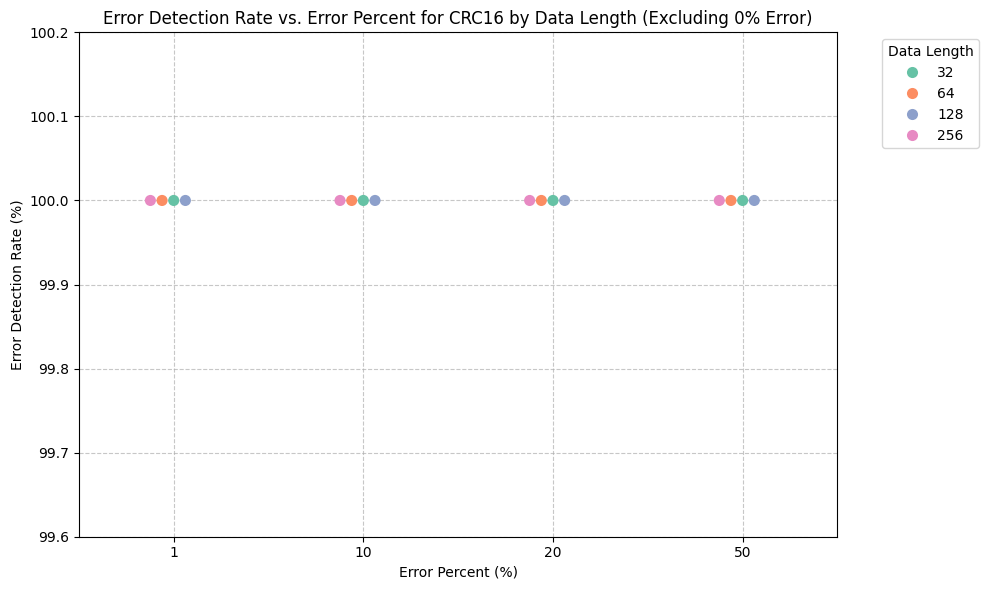

In [80]:
# CRC16 데이터만 필터링하고 ErrorPercent가 0인 값 제외
df_crc16 = df[(df['CRC'] == 'CRC16') & (df['ErrorPercent'] != 0)]

plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_crc16, x='ErrorPercent', y='ErrorDetectionRate_%', hue='DataLength', palette='Set2', s=8)
plt.title('Error Detection Rate vs. Error Percent for CRC16 by Data Length (Excluding 0% Error)')
plt.xlabel('Error Percent (%)')
plt.ylabel('Error Detection Rate (%)')
plt.ylim(min(df_crc16['ErrorDetectionRate_%']) * 0.996, max(df_crc16['ErrorDetectionRate_%']) * 1.002)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

---

## 📊 CRC32: Error Percentage별 Error Detection Rate

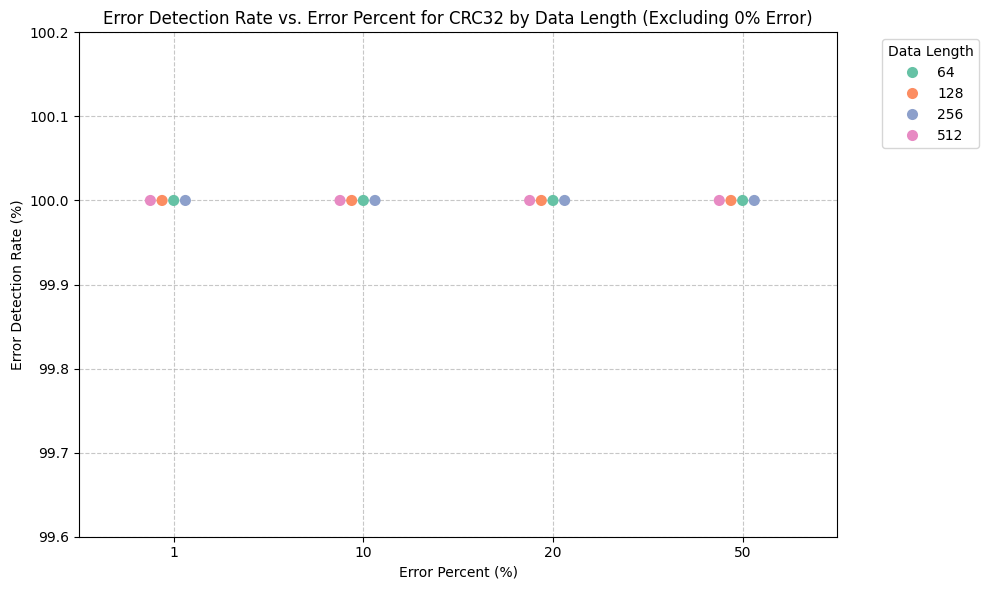

In [81]:
# CRC32 데이터만 필터링하고 ErrorPercent가 0인 값 제외
df_crc32 = df[(df['CRC'] == 'CRC32') & (df['ErrorPercent'] != 0)]

plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_crc32, x='ErrorPercent', y='ErrorDetectionRate_%', hue='DataLength', palette='Set2', s=8)
plt.title('Error Detection Rate vs. Error Percent for CRC32 by Data Length (Excluding 0% Error)')
plt.xlabel('Error Percent (%)')
plt.ylabel('Error Detection Rate (%)')
plt.ylim(min(df_crc32['ErrorDetectionRate_%']) * 0.996, max(df_crc32['ErrorDetectionRate_%']) * 1.002)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Data Length', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()